In [1]:
import os
import spacy
import PyPDF2
import bibtexparser

import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
BIB = 'EX0_POWER_SYSTEM_FPGA_FREQUENCY_ESTIMATORS'

In [4]:
PATH = '/Users/jorge.mayorga/Documents/GitHub/ml-biblio-synth-tool/src/ '
BIB_PATH = './examples/' + BIB
BIB_FILE = BIB_PATH + '/index.bib'
BIB_DOCUMENTS = BIB_PATH + '/files/'
print(BIB_FILE)

./examples/EX0_POWER_SYSTEM_FPGA_FREQUENCY_ESTIMATORS/index.bib


In [5]:
def load_bib_file(filepath):
    """Carga el archivo BibTeX y retorna las entradas."""
    with open(filepath) as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
    return bib_database.entries

In [6]:
def find_pdfs_in_folder(base_folder):
    """Recorre subcarpetas y retorna una lista de PDFs encontrados."""
    pdf_paths = []
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.endswith(".pdf"):
                pdf_paths.append(os.path.join(root, file))
    return pdf_paths

In [7]:
def extract_filename_from_file_field(file_field):
    """Extrae el primer nombre de archivo del campo 'file'."""
    if file_field:
        # Divide por ':' y toma la primera parte
        file = file_field.split(':')[0].split('/')[-1]
        return file
    return None

In [8]:
def normalize_string(string):
    """Elimina espacios y convierte la cadena a mayúsculas."""
    return string.replace(" ", "").upper()

In [9]:
# Emparejamiento simple de PDFs con títulos del .bib
def match_references_with_pdfs(references, pdf_files):
    """Empareja las referencias del .bib con los PDFs disponibles."""
    matched = []
    pdf_names = [normalize_string(os.path.basename(pdf)) for pdf in pdf_files]

    for ref in references:
        file_entry = ref.get('file', '')
        filename = extract_filename_from_file_field(file_entry)

        if filename and normalize_string(filename) in pdf_names:
            pdf_path = next(
                (pdf for pdf in pdf_files 
                 if normalize_string(os.path.basename(pdf)) == normalize_string(filename)), 
                None
            )
            if pdf_path:
                matched.append((ref, pdf_path))
    return matched

In [10]:
def extract_text_from_matched_files(matched_files):
    """Extrae el texto de los PDFs emparejados."""
    extracted_data = []
    for ref, pdf_path in matched_files:
        with open(pdf_path, 'rb') as f:
            reader = PyPDF2.PdfReader(f)
            text = ''.join([page.extract_text() for page in reader.pages])
            extracted_data.append((ref, text))
    return extracted_data


In [11]:
def preprocess_text(text):
    """Tokeniza y lematiza el texto, eliminando stopwords y puntuación."""
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

In [12]:
referencias = load_bib_file(BIB_FILE)
print(referencias[0])  # Ver una referencia de ejemplo

{'file': 'P. et al. - 2009 - Kalman Filter on Power Electronics and Power Syste.pdf:files/8/P. et al. - 2009 - Kalman Filter on Power Electronics and Power Syste.pdf:application/pdf', 'annote': '“Traditionally, power systems problems and applications have been solved by means of purely analog circuits, while an enormous number of digital signal processing and control algorithms have been developed by people working in the communications and control areas.” (P. et al., 2009, p. 397)\n\n“This new area has been applying successfully all the knowledge gathered to improve processes, like power quality monitoring, power system’s protection, power conditioning and synchronization of distributed generators (among others), and the most used digital techniques have been digital filtering, discrete Fourier transform, phased-locked loop tracking methods and more recently, the Kalman filtering (Kalman, 1960).” (P. et al., 2009, p. 397)\n\n“The Kalman filter (KF) was originally proposed to solve a c

In [13]:
pdf_files = find_pdfs_in_folder(BIB_DOCUMENTS)
print(f"PDFs encontrados: {len(pdf_files)}")

PDFs encontrados: 36


In [14]:
matched_files = match_references_with_pdfs(referencias, pdf_files)
print(f"Archivos emparejados: {len(matched_files)}")

Archivos emparejados: 34


In [15]:
# Extraer texto de los PDFs emparejados
extracted_data = extract_text_from_matched_files(matched_files)
print(f"Se extrajo texto de {len(extracted_data)} archivos.")

Se extrajo texto de 34 archivos.


In [16]:
# Lista de nombres de PDFs encontrados en la carpeta
pdf_names = [os.path.basename(pdf) for pdf in pdf_files]

# Lista de PDFs emparejados
matched_pdf_names = [os.path.basename(pdf) for _, pdf in matched_files]

# Identificar el PDF sin emparejar
unmatched_pdfs = set(pdf_names) - set(matched_pdf_names)

if unmatched_pdfs:
    print(f"PDFs sin emparejar ({len(unmatched_pdfs)}):")
    for pdf in unmatched_pdfs:
        print(pdf)
else:
    print("Todos los PDFs fueron emparejados correctamente.")

PDFs sin emparejar (2):
Andrés - 2009 - Measuring academic research how to undertake a bi.pdf
2010 - Ana Andres - How to Undertake a Bibliometric Study.pdf


In [17]:
# Preprocesar los textos extraídos
processed_data = [(ref, preprocess_text(text)) for ref, text in extracted_data]
print(f"Se preprocesaron {len(processed_data)} archivos.")

Se preprocesaron 34 archivos.


In [18]:
# Preparar el texto combinando todo el contenido procesado
all_text = ' '.join([text for _, text in processed_data])
# Imprimir las primeras entradas de processed_data para verificar el contenido
for i, (ref, text) in enumerate(processed_data[:5]):
    print(f"Referencia {i + 1}: {ref.get('title', 'Sin título')}")
    print(f"Texto: {text[:500]}")  # Muestra los primeros 500 caracteres
    print("-" * 80)

Referencia 1: Kalman {Filter} on {Power} {Electronics} and {Power} {Systems} {Applications}
Texto: 17 
 Kalman Filter Power Electronics Power 
 Systems Applications 
 Fernando P. Marafão1 Diego Colón1 Marcelo S. de Padua2   
 Sigmar M. Deckmann2    
 São Paulo State University1  
 University Campinas2 
 Brazil 
 1 introduction 
 decade development take place separately area power 
 system digital signal processing automatic control despite isolated case 
 trajectory touch time area benefit 
 year traditionally power system problem 
 application solve mean purely analog circuit enormous 
 numb
--------------------------------------------------------------------------------
Referencia 2: Power {System} {Frequency} {Estimation} {Algorithm} for {Electric} {Energy} {Metering} of {Nonlinear} {Loads}
Texto:  
 Metrol Meas Syst Vol XIX 2012 2 pp 307 320 
 
 article history receive Dec. 6 2011 receive revise form March 18 2012 accept March 27 2012 available online  
 18 2012 DOI 10.2478 v10178 

In [19]:
# Eliminar caracteres no deseados
import re
cleaned_text = re.sub(r'[^a-zA-Z\s]', '', all_text)
print(f"Longitud del texto limpio: {len(cleaned_text)}")

Longitud del texto limpio: 3369251


In [20]:
print(f"Longitud del texto: {len(all_text)}")
print(f"Primeros 500 caracteres:\n{all_text[:500]}")

Longitud del texto: 3584783
Primeros 500 caracteres:
17 
 Kalman Filter Power Electronics Power 
 Systems Applications 
 Fernando P. Marafão1 Diego Colón1 Marcelo S. de Padua2   
 Sigmar M. Deckmann2    
 São Paulo State University1  
 University Campinas2 
 Brazil 
 1 introduction 
 decade development take place separately area power 
 system digital signal processing automatic control despite isolated case 
 trajectory touch time area benefit 
 year traditionally power system problem 
 application solve mean purely analog circuit enormous 
 numb


In [21]:
try:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)
    print("Nube de palabras generada correctamente.")
except ValueError as e:
    print(f"Error generando la nube de palabras: {e}")

Nube de palabras generada correctamente.


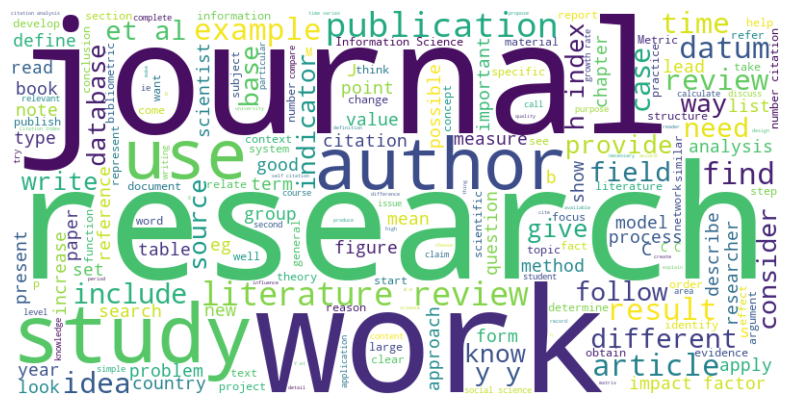

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()